In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset

# Set a random seed
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Define constants
MAX_LEN = 200
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.slokas = dataframe['slokas']  
        self.targets = self.dataframe['list']
        self.max_len = max_len

    def __len__(self):
        return len(self.slokas) 

    def __getitem__(self, index):
        slokas = str(self.slokas[index]) 
        slokas = " ".join(slokas.split())

        inputs = self.tokenizer.encode_plus(
            slokas, 
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

     

In [2]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [3]:
torch.save(model.state_dict(), 'weights_only.pth')


In [4]:
# Load the pre-trained BERT model
bert = BERT()
bert.load_state_dict(torch.load('weights_only.pth', map_location=torch.device('cpu')))
bert.to(device)


torch.save(model.state_dict(), 'weights_only.pth')

# Create a new model
model_new = BERT()
model_new.to(device)

# Load the state dictionary from the local file
model_new.load_state_dict(torch.load('weights_only.pth', map_location=device))


<All keys matched successfully>

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

def test(test_loader, bert):
    bert.eval()
    bert_outputs = []

    with torch.no_grad(): 
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = bert(ids, mask, token_type_ids)

            bert_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return bert_outputs

# Process both CSV files
csv_files = ['GptSanskrit.csv','GeminiSanskrit.csv', 'Gpt4Sanskrit.csv','OfficialTranslation(Purohit).csv','GoogleTranslateSanskrit.csv']

for file_name in csv_files:
    df = pd.read_csv(file_name)

    # Create a new DataFrame to store sentiment analysis results
    sentiment_df = pd.DataFrame()

    # Copy the 'slokas' column from the original CSV
    sentiment_df['slokas'] = df['slokas'] 

    # Initialize a list of 11 zeros for each row
    values = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] * len(df)
    sentiment_df['list'] = values

    test_dataset = CustomDataset(sentiment_df, tokenizer, MAX_LEN)

    bert_test_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0}
    test_loader = DataLoader(test_dataset, **bert_test_params)

    test_outputs = test(test_loader, model)
    test_outputs = np.array(test_outputs)

    # Process sentiment values and add columns to sentiment_df
    for i in range(test_outputs.shape[0]):
        for j in range(test_outputs.shape[1]):
            if test_outputs[i][j] >= 0.5:
                test_outputs[i][j] = 1
            else:
                test_outputs[i][j] = 0

    sentiment_df['Optimistic'] = "None"
    sentiment_df['Thankful'] = "None"
    sentiment_df['Empathetic'] = "None"
    sentiment_df['Pessimistic'] = "None"
    sentiment_df['Anxious'] = "None"
    sentiment_df['Sad'] = "None"
    sentiment_df['Annoyed'] = "None"
    sentiment_df['Denial'] = "None"
    sentiment_df['Official report'] = "None"
    sentiment_df['Surprise'] = "None"
    sentiment_df['Joking'] = "None"
    sentiment_df = sentiment_df.drop(['list'], axis=1)

    for i in range(len(test_outputs)):
        sentiment_df['Optimistic'].iloc[i] = test_outputs[i][0]
        sentiment_df['Thankful'].iloc[i] = test_outputs[i][1]
        sentiment_df['Empathetic'].iloc[i] = test_outputs[i][2]
        sentiment_df['Pessimistic'].iloc[i] = test_outputs[i][3]
        sentiment_df['Anxious'].iloc[i] = test_outputs[i][4]
        sentiment_df['Sad'].iloc[i] = test_outputs[i][5]
        sentiment_df['Annoyed'].iloc[i] = test_outputs[i][6]
        sentiment_df['Denial'].iloc[i] = test_outputs[i][7]
        sentiment_df['Official report'].iloc[i] = test_outputs[i][8]
        sentiment_df['Surprise'].iloc[i] = test_outputs[i][9]
        sentiment_df['Joking'].iloc[i] = test_outputs[i][10]

    # Save the results to a new CSV file
    output_file_name = 'sentiment_' + file_name
    sentiment_df.to_csv(output_file_name)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/yeshwanthrayavarapu/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/Users/yeshwanthrayavarapu/anaconda3/lib/python3.11/site-packages/transfo

/var/folders/12/37yt9y6n15vcglth5cz1m6b00000gn/T/ipykernel_15730/3795960088.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/12/37yt9y6n15vcglth5cz1m6b00000gn/T/ipykernel_15730/3795960088.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/12/37yt9y6n15vcglth5cz1m6b00000gn/T/ipykernel_15730/3795960088.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


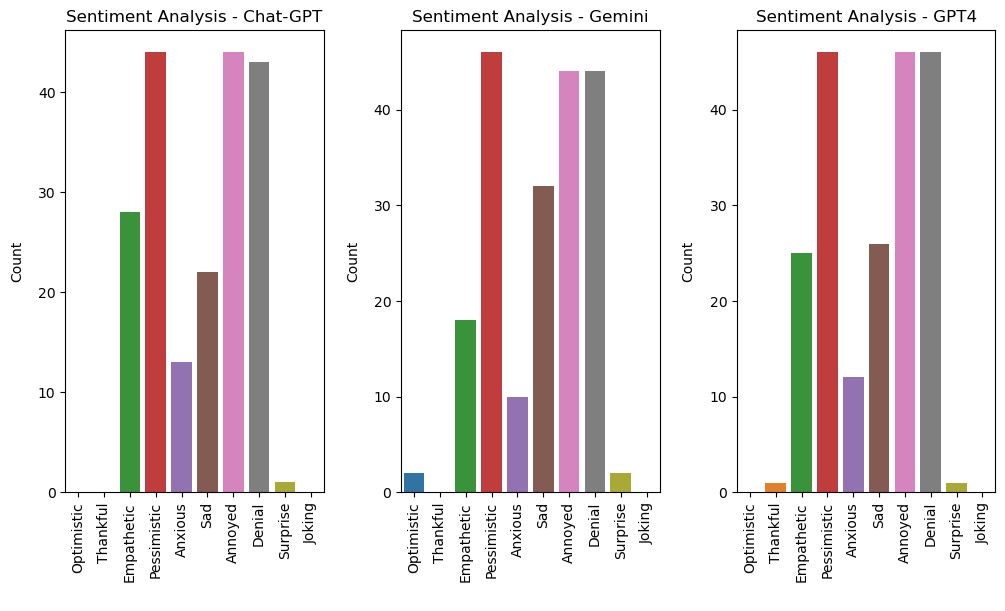

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

# Define the names of the sentiment data files
sentiment_files = ['sentiment_GptSanskrit.csv','sentiment_GeminiSanskrit.csv', 'sentiment_Gpt4Sanskrit.csv','sentiment_OfficialTranslation(Purohit).csv','sentiment_GoogleTranslateSanskrit.csv']
sentiment_sources = ['Chat-GPT','Gemini','GPT4','Purohit','GoogleTranslate']

# Create subplots for each sentiment source
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the horizontal space between subplots

for source, sentiment_file, ax in zip(sentiment_sources, sentiment_files, axes):
    total_df = pd.DataFrame()

    # Load the sentiment data for the current source
    df = pd.read_csv(sentiment_file)

    # Remove unnecessary columns
    df = df.drop(['slokas', 'Unnamed: 0'], axis=1)

    # Fill missing values with 0
    df = df.fillna(0)

    # Sum the counts for each sentiment category
    df = df.sum()

    # Convert to a DataFrame
    df = pd.DataFrame(df)
    df.columns = ['Count']

    # Append to the total_df
    total_df = total_df._append(df)

    # Reset the index and rename columns
    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={"index": "Sentiment"})

    # Create a new DataFrame for the summary
    new_df = pd.DataFrame({
        "Sentiment": ["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Surprise", "Joking"],
        "Count": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    })

    # Calculate the total count for each sentiment category
    for ii in range(0, 10):
        new_df.loc[ii, 'Count'] = total_df.loc[ii, 'Count']
        

    # Create the plot
    sns.barplot(x=new_df.Sentiment, y=new_df.Count, ax=ax, palette=sns.color_palette("tab10"))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('Count', labelpad=10)
    ax.set_xlabel(' ')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_title(f'Sentiment Analysis - {source}', fontsize=12)

plt.show()


/var/folders/12/37yt9y6n15vcglth5cz1m6b00000gn/T/ipykernel_15730/3859572257.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
/var/folders/12/37yt9y6n15vcglth5cz1m6b00000gn/T/ipykernel_15730/3859572257.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


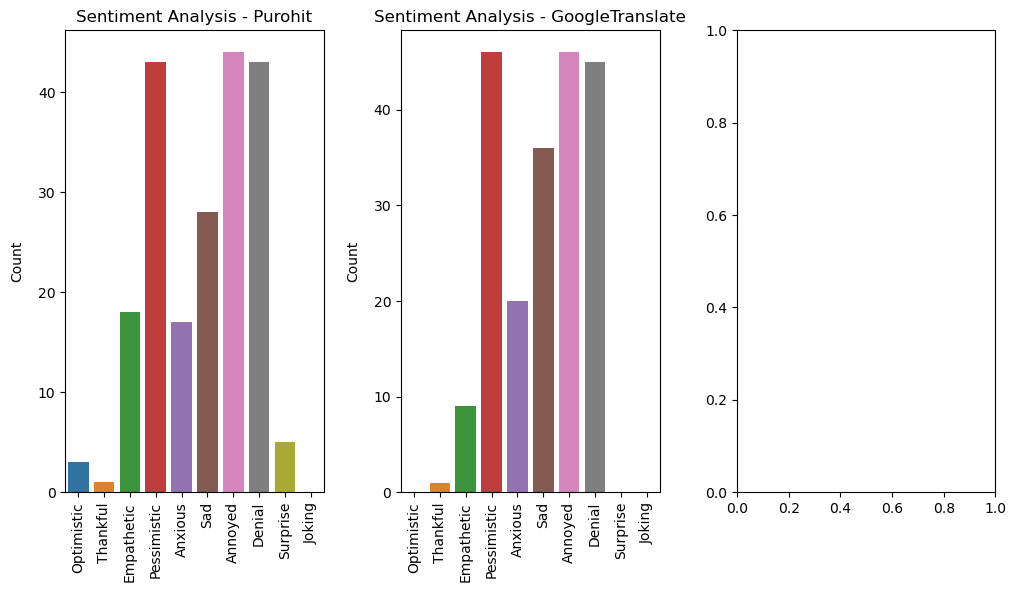

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

# Define the names of the sentiment data files
sentiment_files = ['sentiment_OfficialTranslation(Purohit).csv','sentiment_GoogleTranslateSanskrit.csv']
sentiment_sources = ['Purohit','GoogleTranslate']

# Create subplots for each sentiment source
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the horizontal space between subplots

for source, sentiment_file, ax in zip(sentiment_sources, sentiment_files, axes):
    total_df = pd.DataFrame()

    # Load the sentiment data for the current source
    df = pd.read_csv(sentiment_file)

    # Remove unnecessary columns
    df = df.drop(['slokas', 'Unnamed: 0'], axis=1)

    # Fill missing values with 0
    df = df.fillna(0)

    # Sum the counts for each sentiment category
    df = df.sum()

    # Convert to a DataFrame
    df = pd.DataFrame(df)
    df.columns = ['Count']

    # Append to the total_df
    total_df = total_df._append(df)

    # Reset the index and rename columns
    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={"index": "Sentiment"})

    # Create a new DataFrame for the summary
    new_df = pd.DataFrame({
        "Sentiment": ["Optimistic", "Thankful", "Empathetic", "Pessimistic", "Anxious", "Sad", "Annoyed", "Denial", "Surprise", "Joking"],
        "Count": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    })

    # Calculate the total count for each sentiment category
    for ii in range(0, 10):
        new_df.loc[ii, 'Count'] = total_df.loc[ii, 'Count']
        

    # Create the plot
    sns.barplot(x=new_df.Sentiment, y=new_df.Count, ax=ax, palette=sns.color_palette("tab10"))

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('Count', labelpad=10)
    ax.set_xlabel(' ')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_title(f'Sentiment Analysis - {source}', fontsize=12)

plt.show()
